In [1]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


In [2]:
data_dir = os.curdir + "/Flowers"
# Training data dir
training_dir = os.curdir + '/Train'

# Test data dir
testing_dir = os.curdir + '/Test'

# Ratio of training and testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))

        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

  

        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [3]:
split_dataset_into_test_and_train_sets()

Babi has 931 images
Calimerio has 353 images
Chrysanthemum has 696 images
Hydrangeas has 518 images
Lisianthus has 969 images
Pingpong has 360 images
Rosy has 171 images
Tana has 623 images
Processed 3696 training files.
Processed 925 testing files.


In [2]:
# Defining the imagedatagenerator for train and test image for pre-processing
# We don't give horizonal_flip or other preprocessing for validation data generator
data_dir = os.curdir + "/Flowers"
# Training data dir
training_dir = os.curdir + '/Train'

# Test data dir
testing_dir = os.curdir + '/Test'

image_size = 224
batch_size = 64

train_data_gen = ImageDataGenerator(
    rescale = 1./255, #normalization
    rotation_range = 40,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
    horizontal_flip = True)
valid_data_gen = ImageDataGenerator(rescale = 1./255)
train_generator = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(testing_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 3696 images belonging to 8 classes.
Found 925 images belonging to 8 classes.


In [9]:
def create_cnn_model(dropout_rate, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name = 'encoder'))
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(8, activation = "softmax"))
    # Compile model
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])  
    return model

Epoch 1/50
57/57 [==============================] - 116s 2s/step - loss: 1.9968 - accuracy: 0.2040 - val_loss: 1.9823 - val_accuracy: 0.2143
Epoch 2/50
57/57 [==============================] - 112s 2s/step - loss: 1.9762 - accuracy: 0.2161 - val_loss: 1.9705 - val_accuracy: 0.2143
Epoch 3/50
57/57 [==============================] - 112s 2s/step - loss: 1.9711 - accuracy: 0.2241 - val_loss: 1.9693 - val_accuracy: 0.2746
Epoch 4/50
57/57 [==============================] - 113s 2s/step - loss: 1.9628 - accuracy: 0.2365 - val_loss: 1.9573 - val_accuracy: 0.2812
Epoch 5/50
57/57 [==============================] - 113s 2s/step - loss: 1.9577 - accuracy: 0.2472 - val_loss: 1.9476 - val_accuracy: 0.2567
Epoch 6/50
57/57 [==============================] - 113s 2s/step - loss: 1.9421 - accuracy: 0.2572 - val_loss: 1.9370 - val_accuracy: 0.2902
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.9332 - accuracy: 0.2616 - val_loss: 1.9187 - val_accuracy: 0.2891
Epoch 8/50
57

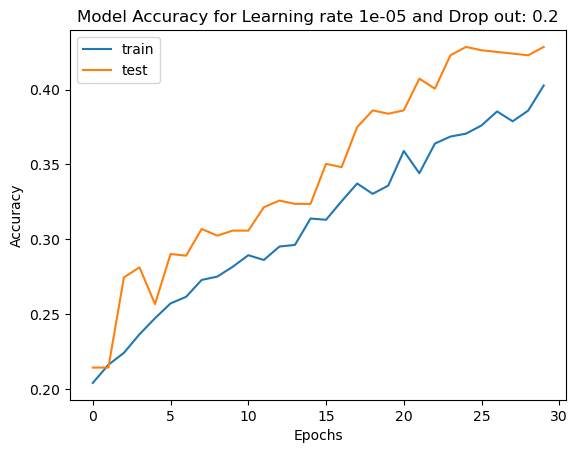

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 2.0002 - accuracy: 0.1922 - val_loss: 2.0070 - val_accuracy: 0.2143
Epoch 2/50
57/57 [==============================] - 112s 2s/step - loss: 1.9798 - accuracy: 0.2109 - val_loss: 2.0102 - val_accuracy: 0.2121
Epoch 3/50
57/57 [==============================] - 113s 2s/step - loss: 1.9760 - accuracy: 0.2219 - val_loss: 1.9978 - val_accuracy: 0.2645
Epoch 4/50
57/57 [==============================] - 112s 2s/step - loss: 1.9676 - accuracy: 0.2247 - val_loss: 1.9942 - val_accuracy: 0.2578
Epoch 5/50
57/57 [==============================] - 112s 2s/step - loss: 1.9656 - accuracy: 0.2307 - val_loss: 1.9870 - val_accuracy: 0.2444
Epoch 6/50
57/57 [==============================] - 112s 2s/step - loss: 1.9511 - accuracy: 0.2431 - val_loss: 1.9807 - val_accuracy: 0.3170
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.9389 - accuracy: 0.2442 - val_loss: 1.9683 - val_accuracy: 0.2723
Epoch 8/50
57

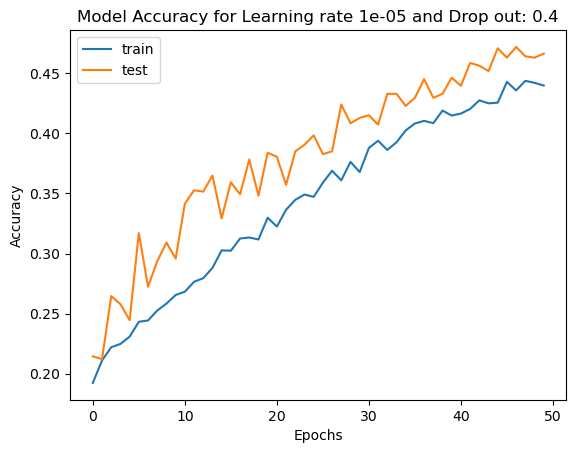

Epoch 1/50
57/57 [==============================] - 113s 2s/step - loss: 1.9747 - accuracy: 0.2159 - val_loss: 1.9475 - val_accuracy: 0.2377
Epoch 2/50
57/57 [==============================] - 113s 2s/step - loss: 1.9180 - accuracy: 0.2662 - val_loss: 1.8857 - val_accuracy: 0.2879
Epoch 3/50
57/57 [==============================] - 113s 2s/step - loss: 1.8464 - accuracy: 0.2941 - val_loss: 1.7810 - val_accuracy: 0.3225
Epoch 4/50
57/57 [==============================] - 113s 2s/step - loss: 1.7803 - accuracy: 0.3318 - val_loss: 1.6885 - val_accuracy: 0.3817
Epoch 5/50
57/57 [==============================] - 113s 2s/step - loss: 1.7096 - accuracy: 0.3717 - val_loss: 1.6271 - val_accuracy: 0.3962
Epoch 6/50
57/57 [==============================] - 114s 2s/step - loss: 1.6537 - accuracy: 0.3970 - val_loss: 1.5629 - val_accuracy: 0.4353
Epoch 7/50
57/57 [==============================] - 113s 2s/step - loss: 1.6038 - accuracy: 0.4180 - val_loss: 1.5042 - val_accuracy: 0.4866
Epoch 8/50
57

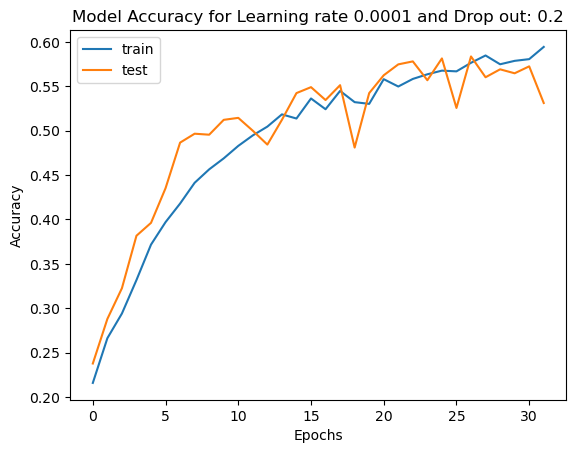

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 1.9901 - accuracy: 0.2059 - val_loss: 1.9864 - val_accuracy: 0.2623
Epoch 2/50
57/57 [==============================] - 113s 2s/step - loss: 1.9541 - accuracy: 0.2439 - val_loss: 1.9663 - val_accuracy: 0.3047
Epoch 3/50
57/57 [==============================] - 112s 2s/step - loss: 1.9056 - accuracy: 0.2676 - val_loss: 1.8805 - val_accuracy: 0.3471
Epoch 4/50
57/57 [==============================] - 113s 2s/step - loss: 1.8321 - accuracy: 0.3108 - val_loss: 1.8133 - val_accuracy: 0.3917
Epoch 5/50
57/57 [==============================] - 114s 2s/step - loss: 1.7620 - accuracy: 0.3439 - val_loss: 1.7426 - val_accuracy: 0.3917
Epoch 6/50
57/57 [==============================] - 113s 2s/step - loss: 1.6927 - accuracy: 0.3775 - val_loss: 1.6833 - val_accuracy: 0.4431
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.6147 - accuracy: 0.4089 - val_loss: 1.6263 - val_accuracy: 0.4688
Epoch 8/50
57

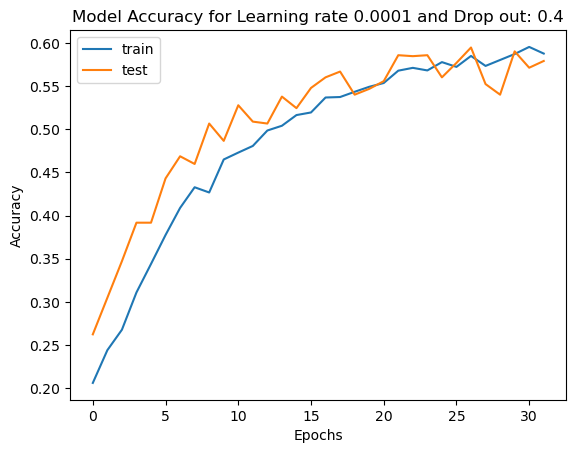

Epoch 1/50
57/57 [==============================] - 113s 2s/step - loss: 2.0766 - accuracy: 0.2070 - val_loss: 1.9914 - val_accuracy: 0.2031
Epoch 2/50
57/57 [==============================] - 113s 2s/step - loss: 1.9597 - accuracy: 0.2346 - val_loss: 1.8711 - val_accuracy: 0.3203
Epoch 3/50
57/57 [==============================] - 111s 2s/step - loss: 1.9174 - accuracy: 0.2706 - val_loss: 1.9201 - val_accuracy: 0.3080
Epoch 4/50
57/57 [==============================] - 112s 2s/step - loss: 1.8393 - accuracy: 0.3111 - val_loss: 1.7709 - val_accuracy: 0.3538
Epoch 5/50
57/57 [==============================] - 113s 2s/step - loss: 1.7492 - accuracy: 0.3676 - val_loss: 1.6701 - val_accuracy: 0.3996
Epoch 6/50
57/57 [==============================] - 112s 2s/step - loss: 1.6252 - accuracy: 0.4061 - val_loss: 1.5626 - val_accuracy: 0.4096
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.5701 - accuracy: 0.4265 - val_loss: 1.5901 - val_accuracy: 0.3895
Epoch 8/50
57

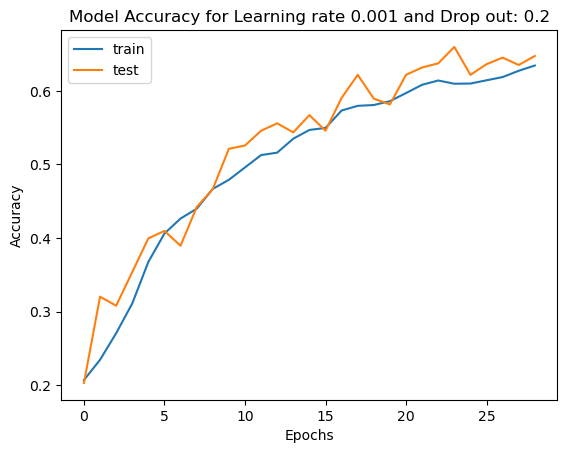

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 2.0767 - accuracy: 0.1982 - val_loss: 1.9939 - val_accuracy: 0.2087
Epoch 2/50
57/57 [==============================] - 111s 2s/step - loss: 1.9372 - accuracy: 0.2398 - val_loss: 1.9283 - val_accuracy: 0.3147
Epoch 3/50
57/57 [==============================] - 112s 2s/step - loss: 1.8694 - accuracy: 0.3048 - val_loss: 1.8568 - val_accuracy: 0.3259
Epoch 4/50
57/57 [==============================] - 112s 2s/step - loss: 1.8360 - accuracy: 0.3232 - val_loss: 1.8239 - val_accuracy: 0.3147
Epoch 5/50
57/57 [==============================] - 111s 2s/step - loss: 1.7171 - accuracy: 0.3775 - val_loss: 1.6379 - val_accuracy: 0.4509
Epoch 6/50
57/57 [==============================] - 111s 2s/step - loss: 1.5909 - accuracy: 0.4207 - val_loss: 1.6474 - val_accuracy: 0.4621
Epoch 7/50
57/57 [==============================] - 111s 2s/step - loss: 1.5721 - accuracy: 0.4347 - val_loss: 1.5215 - val_accuracy: 0.4766
Epoch 8/50
57

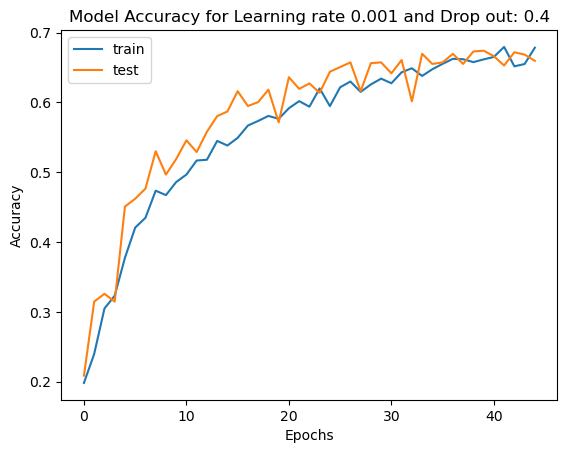

Epoch 1/50
57/57 [==============================] - 111s 2s/step - loss: 8.1481 - accuracy: 0.1925 - val_loss: 1.9686 - val_accuracy: 0.2042
Epoch 2/50
57/57 [==============================] - 111s 2s/step - loss: 1.9750 - accuracy: 0.2040 - val_loss: 1.9730 - val_accuracy: 0.2098
Epoch 3/50
57/57 [==============================] - 110s 2s/step - loss: 1.9733 - accuracy: 0.2084 - val_loss: 1.9729 - val_accuracy: 0.2009
Epoch 4/50
57/57 [==============================] - 111s 2s/step - loss: 1.9731 - accuracy: 0.2098 - val_loss: 1.9707 - val_accuracy: 0.1953
Epoch 5/50
57/57 [==============================] - 110s 2s/step - loss: 1.9733 - accuracy: 0.2051 - val_loss: 1.9652 - val_accuracy: 0.2042
Epoch 6/50
57/57 [==============================] - 111s 2s/step - loss: 1.9737 - accuracy: 0.2128 - val_loss: 1.9738 - val_accuracy: 0.2132
Epoch 7/50
57/57 [==============================] - 111s 2s/step - loss: 1.9727 - accuracy: 0.2137 - val_loss: 1.9705 - val_accuracy: 0.2054
Epoch 8/50
57

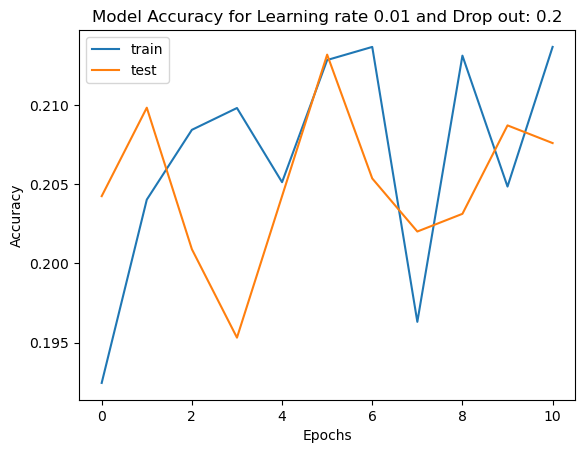

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 24.0682 - accuracy: 0.2051 - val_loss: 1.9748 - val_accuracy: 0.2109
Epoch 2/50
57/57 [==============================] - 111s 2s/step - loss: 1.9796 - accuracy: 0.2059 - val_loss: 1.9695 - val_accuracy: 0.2098
Epoch 3/50
57/57 [==============================] - 111s 2s/step - loss: 1.9765 - accuracy: 0.2046 - val_loss: 1.9686 - val_accuracy: 0.2143
Epoch 4/50
57/57 [==============================] - 116s 2s/step - loss: 1.9745 - accuracy: 0.2084 - val_loss: 1.9700 - val_accuracy: 0.2042
Epoch 5/50
57/57 [==============================] - 111s 2s/step - loss: 1.9721 - accuracy: 0.2010 - val_loss: 1.9702 - val_accuracy: 0.2098
Epoch 6/50
57/57 [==============================] - 111s 2s/step - loss: 1.9718 - accuracy: 0.2026 - val_loss: 1.9722 - val_accuracy: 0.2087
Epoch 7/50
57/57 [==============================] - 110s 2s/step - loss: 1.9748 - accuracy: 0.2093 - val_loss: 1.9732 - val_accuracy: 0.2076
Epoch 8/50
5

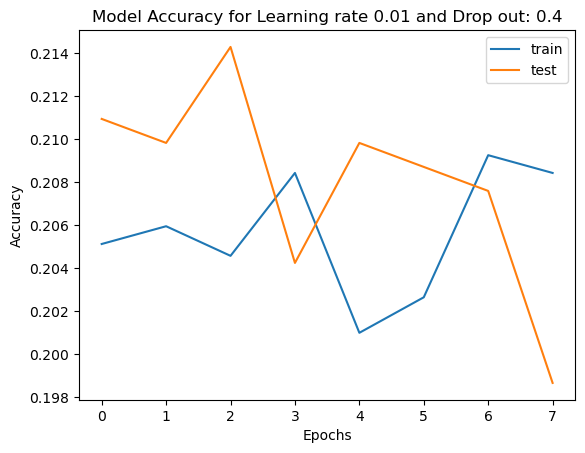

In [11]:
models = []
lr_params = [1e-5, 1e-4, 1e-3, 1e-2]
dropout_params = [0.2, 0.4]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

for lr in lr_params:
    for dropout in dropout_params:
        buf = create_cnn_model(dropout, lr)
        history = buf.fit(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//batch_size,
        epochs=50,
        verbose=1, callbacks=[early_stopping])
        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy for Learning rate ' + str(lr) + ' and Drop out: ' + str(dropout))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.show()
        models.append(buf)


In [ ]:
models = []
lr_params = [1e-3, 1e-2]
dropout_params = [0.2, 0.4]

for dropout in dropout_params:
    for lr in lr_params:
        buf = create_cnn_model(dropout, lr)
        history = buf.fit(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//batch_size,
        epochs=80,
        verbose=1)
        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy for Learning rate ' + str(lr) + ' and Drop out: ' + str(dropout))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.show()
        models.append(buf)


Epoch 1/80
57/57 [==============================] - 120s 2s/step - loss: 2.0156 - accuracy: 0.2068 - val_loss: 1.9785 - val_accuracy: 0.2087
Epoch 2/80
35/57 [=================>............] - ETA: 43s - loss: 1.9661 - accuracy: 0.2055